<a href="https://colab.research.google.com/github/yvesheri4/short-pulse-electron-beam-python/blob/main/Particle_motion_IVEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper 1 - Space charge effects

____

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import constants
import seaborn as sns
eps_0 = constants.epsilon_0
from matplotlib import cm

size = 24
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':1.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

### Particles

In [ ]:
import numpy as np
from scipy import constants as cst

# Define the particle class
class Particle:
    def __init__(self, mass,charge, index):
        self.mass = mass
        self.i = index
        self.charge = charge
        self.r = np.zeros((1), dtype='float64')
        self.v = np.zeros((1), dtype='float64')

    def initPos(self, x):
        self.r = x

    def initSpeed(self, vx):
        self.v = vx

    def Heri_push(self, dt, E):
        temp = self.v
        self.v += 1.5*E*dt
        self.r += 3*(self.v+temp)*dt/2

### Functions

#### Particles related functions

In [ ]:
def Create_Particle_list(mass,charge):
    List = []
    for i in range(len(charge)):
        List.append(Particle(mass[i],charge[i],i+1))
    return List

def Init_Particle_list(List,InitPos,InitSpeed):
    for i in range(len(List)):
        List[i].initPos(InitPos[i])
        List[i].initSpeed(InitSpeed[i])
    return List


#### Fields related functions

In [ ]:
def Electric_Field(List,V0,d,t,Dt):

    N_inj = 1+int(t/Dt)
    if N_inj > len(List):
        N_inj = len(List)

    E = np.zeros(len(List))

    sum1 = 0
    List2 = []
    for j in range(N_inj):
        if List[j].r < 1 and List[j].r >=0:
            sum1 += (List[j].charge*List[j].r)
            List2.append(List[j])

    for j in range(len(List2)):
        sum2 = 0
        for i in range(j):
            sum2 += List2[i].charge
        E[List2[j].i-1] = 1 + (sum1 - sum2 - 0.5*List2[j].charge)

    return E

def Current_density(Vel,rho):

    len_t = Vel.shape[0]
    N_sheet = Vel.shape[1]
    J = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            sum1 += 3*Vel[i][j]*rho[j]
        J[i] = sum1

    return J

def Field_cathode(Pos,rho,V0,d):

    E0 = -V0/d

    len_t = Pos.shape[0]
    N_sheet = Pos.shape[1]
    E = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            if Pos[i][j] < 1 and Pos[i][j] > 0:
                sum1 += rho[j]*(Pos[i][j] - 1)

        E[i] = 1 + sum1

    return E

def Potential(Pos,rho,V0,d):

    E0 = -V0/d

    len_t = Pos.shape[0]
    N_sheet = Pos.shape[1]
    E = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            if Pos[i][j] < d and Pos[i][j] > 0:
                sum1 += rho[j]*(Pos[i][j] - d)/(eps_0*d)

        E[i] = E0 + sum1

    return E

#### Simulations related

In [ ]:
def Simulation(t_sim,Sys_Params,InitCond,k=100):

    time = np.linspace(0,t_sim,k)
    dt = time[1]-time[0]

    InitPos,InitSpeed = InitCond
    Dt,mass,charge,V0,d = Sys_Params

    List_part = Create_Particle_list(mass,charge)

    List_part = Init_Particle_list(List_part,InitPos,InitSpeed)
#     print(List_part[0].r)

    position = np.zeros([len(time),len(List_part)])
    velocity = np.zeros([len(time),len(List_part)])
    E_field = np.zeros([len(time),len(List_part)])

    count = 0

    for t in time:
        E = Electric_Field(List_part,V0,d,t,Dt)
        E_field[count] = E

        for j in range(len(List_part)):
            position[count][j] = List_part[j].r
            velocity[count][j] = List_part[j].v

            if List_part[j].r < 1 and List_part[j].r >=0:
                List_part[j].Heri_push(dt,E[j])
            else:
#                 List_part[j].r = d
                List_part[j].v = 0

        count += 1

    return position,velocity,E_field

def Initial_position(N,params):
    e,E,m,dt  = params
    XV0 = np.zeros(N) # Initial conditions
    Dx_k = sheets_spacing(e,E,m,dt)

    for i in range(N):
        XV0[i] = (N-i)*Dx_k  # Sheet N is located at the cathode

    return XV0

def distorsion(position,time,Dt,M):
    t_init = Dt*(M-1)
    i = 0
    while  position[i,0] < 1:
        i +=1

    j = 0

    while  position[j,-1] < 1:
        j +=1

    t_final = time[j] - time[i]
    Distorsion = t_final / t_init

    return Distorsion

def Norm_J_crit_s(Xcl):

    return (3/4)/Xcl

def Norm_J_crit_e(Xcl):

    T1 = 2*(1-np.sqrt(1-(3/4)*Xcl**2))/Xcl**3

    return T1

def limit_charge(T0,Params_sys,ini_conds,iterations):

    tol = 1e-7

    Indicator = False
    position,velocity,E_field = Simulation(T0,Params_sys,ini_conds,iterations)

    if (position[-1,:] - position[0,:] < tol ).any():

    # if abs(position[-1,-1] - position[0,-1]) < tol  :
#     if (position[-1,-1] - position[0,-1] < tol ) :

        Indicator = True

    return Indicator

# def sheets_spacing(mass,) = lambda e,E,m,dt: 0.5*(e*E/m)*(dt**2)

Time_transit = lambda Vg,d : np.sqrt(2*d/(cst.e*Vg/(d*cst.m_e)))

Sigma_1 = lambda Vg,d : -cst.epsilon_0*Vg/d

#### Plots

In [ ]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=2):

#     lag = int(len(position[0])/n)

    lag = 5000

    len_rho = len(rho)

    psum = [6.2665706768411304,12.499856013286099,17.94732608456735,21.721125396120463]

    for i in range(1,n+2):
        if i == n:
            lag = lag - 1

        plt.figure(figsize=(10,2.75))

#         print(i*lag*Dt_b*Tcl/T0)


        for j in range(len_rho):

            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.title("Pulse profile")
            plt.plot(shape[0],shape[1],lw=1,label=f"$\\rho/\\rho^*$ = {int(100*(j+1)*0.25)}%")
#             plt.plot(shape[0],shape[1],lw=5,label=f"a = {round(1/psum[j],2)}, b= {2*((j+1)*2.5)**2}")

#             plt.xlabel("Position")
            plt.ylabel("Charge")
            plt.legend(fontsize=8)
            plt.xlim(0,1)
        ######################################################


            K = np.array([0])
            A = np.array([1])
            E_K = np.array([field[1][-1]])
            E_A = np.array([field[1][0]])
            con1 = np.concatenate((A, field[0],K))
            con2 = np.concatenate((E_A, field[1],E_K))

            plt.subplot(1,3,2)
            plt.title("E field")
#             plt.plot(field[0],field[1],lw=3)
            plt.plot(con1,con2,lw=1)
#             plt.xlabel("Position")
            plt.ylabel("E")
            plt.xlim(0,1)

        ######################################################

            plt.subplot(1,3,3)
            plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=1)
#             plt.xlabel("Position")
            plt.ylabel("Velocity")
            plt.xlim(0,1)

            plt.tight_layout(pad=.3)

#         plt.savefig(f'snapshots_sq{j}.jpg', dpi=400)
        plt.show()

In [ ]:
# position_sq.shape

____

In [ ]:

def gaussian_profile(rho_M,M=30,x=5):
    i = np.arange(1,M+1,1)
    u = (M+1)/2
    prof_ = np.exp(-((i-u)**2)/(2*x**2))
    psum = 0
    for j in i:
        psum += np.exp(-((j-u)**2)/(2*x**2))
    prof_ = prof_/psum
    print(psum)
    return prof_

def trapezoid_profile(rho_M,M=30,tr=0.25,tf=0.25):
    Nr = int(M*tr)
    Nf = int(M*tf)
    No = M - Nr - Nf
    prof_ = np.zeros(M)

    for i in range(M):
        if i < Nr:
            prof_[i] = (rho_M/Nr)*(i+1)
        if i >= Nr and i < Nr+No:
            prof_[i] = rho_M
        if i >= Nr+No:
            prof_[i] = (rho_M/Nf)*(M-i)

    return prof_/sum(prof_)

Time_CL = lambda Vg,d : 3*d/np.sqrt(2*cst.e*Vg/cst.m_e)


def pulse_profile(N,Sigma, Type = 'square',sd = 5,tr=0.25,tf=0.25):
    Type = Type.lower()
    if Type == 'square':
        return np.ones(N)*Sigma
    if Type == 'gauss':
        return gaussian_profile(Sigma,N,sd)
    if Type == 'trapezoid':
        return trapezoid_profile(Sigma,N,tr=0.25,tf=0.25)
    else:
        return print('Profile not recognized')

#### Plots

____

# Injection Simulation

## Parameters

In [ ]:
V0 = 30e3
d = 1.5e-3
M = 40
rho_SCL = Sigma_1(V0,d)
T0 = Time_transit(V0,d)
Tcl = Time_CL(V0,d)

iterations = 30000
Dt = (T0/Tcl)/M
kp = .1
fp = 1

ini_pos = np.zeros(M)
ini_speed = np.zeros(M)
ini_conds = [ini_pos,ini_speed]

time = np.linspace(0, 3,iterations)

In [ ]:
1/M

0.025

## 1. Trajectories

In [ ]:
rho_SCL

-0.00017708375625600001

In [ ]:
charge = 1/M
mass = constants.m_e*abs(charge/constants.e)

12.532369520882824
12.532369520882824


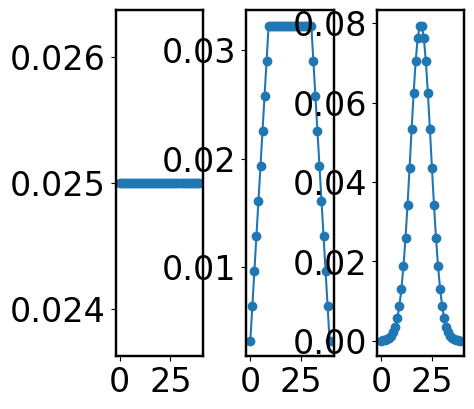

In [ ]:
Sq_charge = pulse_profile(M,1)*charge
Tr_charge = pulse_profile(M,1,Type = 'trapezoid')
Ga_charge = pulse_profile(M,1,Type = 'gauss')

Sq_mass = pulse_profile(M,1)
Tr_mass = pulse_profile(M,1,Type = 'trapezoid')
Ga_mass = pulse_profile(M,1,Type = 'gauss')

# set the spacing between subplots
plt.subplots_adjust(wspace=.5)

plt.subplot(131)
plt.plot(Sq_charge,'o-')

plt.subplot(132)
plt.plot(Tr_charge,'o-')


plt.subplot(133)
plt.plot(Ga_charge,'o-')
# print(Ga_charge)

In [ ]:
Sq_mass

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

____

### 1.1 Sheet trajectories

In [ ]:
plt.rc('font', family='serif')

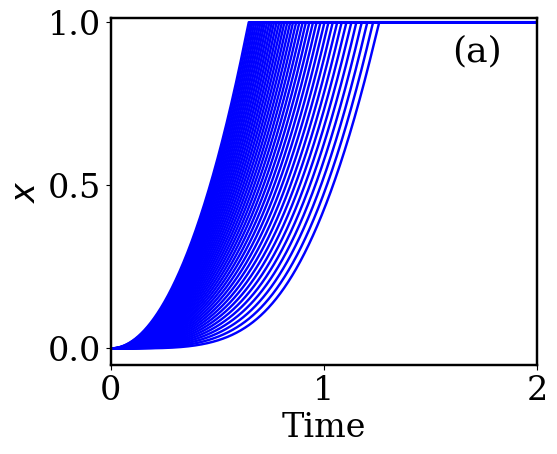

In [ ]:
kp = 0.1
fp = 1.01

Sq_Params_sys = [kp*Dt,fp*Sq_mass,fp*Sq_charge,V0,d]

position_sq,velocity_sq,E_field_sq = Simulation(3,Sq_Params_sys,ini_conds,iterations)
plt.figure(figsize=(5.5,4.5))
plt.plot(time,position_sq,'blue',lw=1.75)

plt.xlim(0,2)
plt.xlabel('Time',fontsize=24)
plt.ylim(-0.05,1.0125)
plt.ylabel('$x$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

plt.text(1.6, 0.88, '(a)', fontsize=26)
plt.savefig('position_sq.png',bbox_inches='tight', dpi=300)
plt.show()

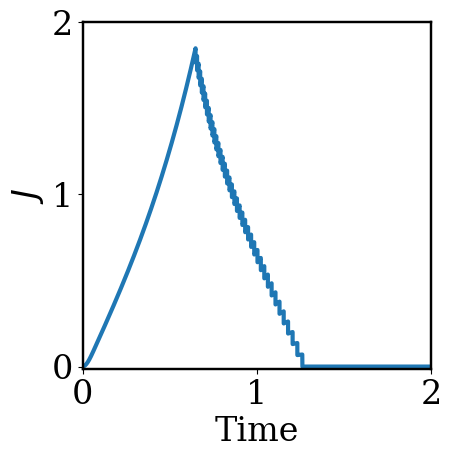

In [ ]:
J_sq = Current_density(velocity_sq,Sq_charge)
plt.plot(time,J_sq,lw=3)
plt.xlim(0,2)
plt.xlabel('Time')
plt.ylim(-0.0125,2)
plt.ylabel('$J$')
# plt.text(2, 1.35, '(a)', fontsize=18)
plt.locator_params(axis='y', nbins=3)

plt.savefig('Current_sq.png',bbox_inches='tight', dpi=300)
plt.show()

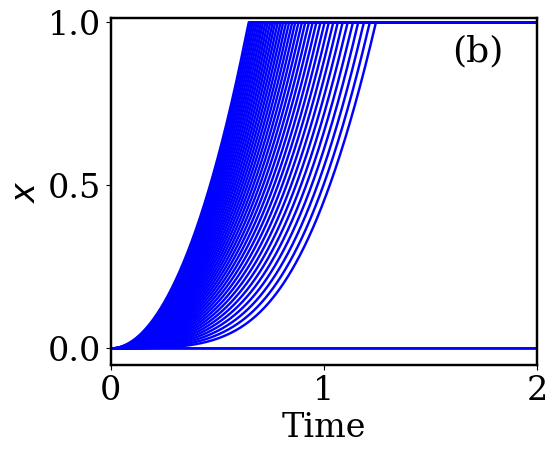

In [ ]:
kp = 0.1
fp = 1.05

Sq_Params_sys = [kp*Dt,fp*Sq_mass,fp*Sq_charge,V0,d]

position_sq,velocity_sq,E_field_sq = Simulation(3,Sq_Params_sys,ini_conds,iterations)
plt.figure(figsize=(5.5,4.5))
plt.plot(time,position_sq,'blue',lw=1.75)

plt.xlim(0,2)
plt.xlabel('Time',fontsize=24)
plt.ylim(-0.05,1.0125)
plt.ylabel('$x$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

plt.text(1.6, 0.88, '(b)', fontsize=26)
plt.savefig('position_sq.png',bbox_inches='tight', dpi=300)
plt.show()

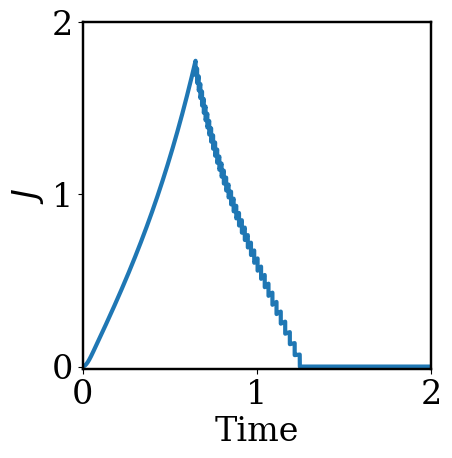

In [ ]:
J_sq = Current_density(velocity_sq,Sq_charge)
plt.plot(time,J_sq,lw=3)
plt.xlim(0,2)
plt.xlabel('Time')
plt.ylim(-0.0125,2)
plt.ylabel('$J$')

plt.locator_params(axis='y', nbins=3)

plt.savefig('Current_sq.png',bbox_inches='tight', dpi=300)
plt.show()

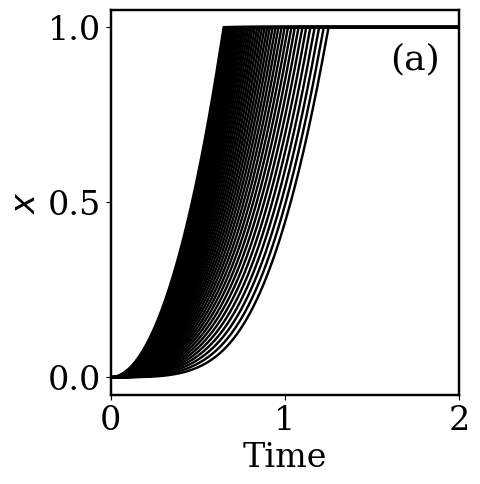

In [ ]:
kp = 0.1
fp = 1

Sq_Params_sys = [kp*Dt,fp*Sq_mass,fp*Sq_charge,V0,d]

position_sq,velocity_sq,E_field_sq = Simulation(3,Sq_Params_sys,ini_conds,iterations)
plt.figure(figsize=(4.5,5))
plt.plot(time,position_sq,'black',lw=1.75)

plt.xlim(0,2)
plt.xlabel('Time',fontsize=24)
plt.ylim(-0.05,1.05)
plt.ylabel('$x$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

plt.text(1.6, 0.88, '(a)', fontsize=26)
plt.savefig('position_sq.png',bbox_inches='tight', dpi=300)
plt.show()

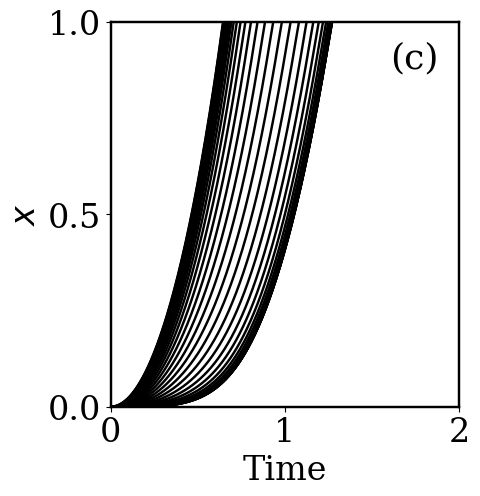

In [ ]:
Ga_Params_sys = [kp*Dt,fp*Ga_mass,fp*Ga_charge,V0,d]

position_ga,velocity_ga,E_field_ga = Simulation(3,Ga_Params_sys,ini_conds,iterations)
plt.figure(figsize=(4.5,5))
plt.plot(time,position_ga,'black',lw=1.75)

plt.xlim(0,2)
plt.xlabel('Time',fontsize=24)
plt.ylim(0.0,1)
plt.ylabel('$x$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.text(1.6, 0.88, '(c)', fontsize=26)
plt.savefig('position_ga.png',bbox_inches='tight', dpi=300)
plt.show()

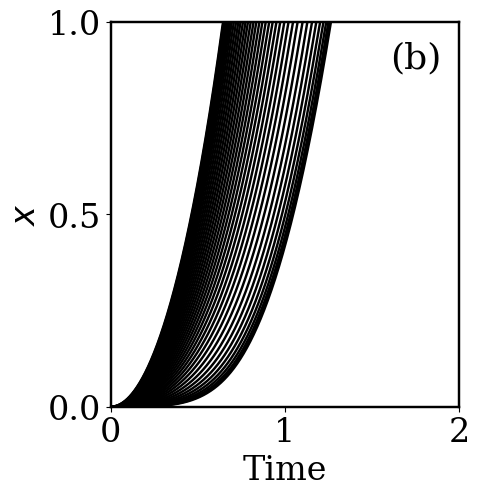

In [ ]:
Tr_Params_sys = [kp*Dt,fp*Tr_mass,fp*Tr_charge,V0,d]

position_tr,velocity_tr,E_field_tr = Simulation(3,Tr_Params_sys,ini_conds,iterations)
plt.figure(figsize=(4.5,5))
plt.plot(time,position_tr,'black',lw=1.75)

plt.xlim(0,2)
plt.xlabel('Time',fontsize=24)
plt.ylim(0,1)
plt.ylabel('$x$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.text(1.6, 0.88, '(b)', fontsize=26)
plt.savefig('position_tr.png',bbox_inches='tight', dpi=300)
plt.show()

# plt.plot(time*1e12,velocity_tr*1e3,'black',lw=2.5)

### 1.2 Current density

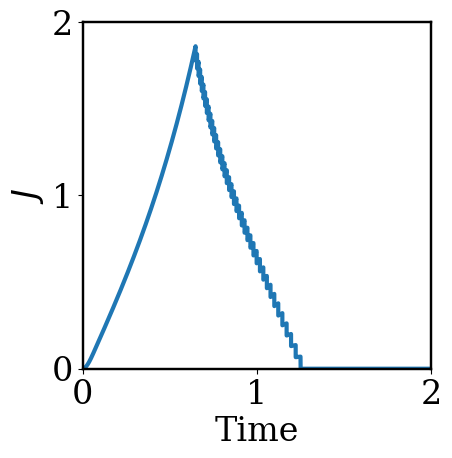

In [ ]:
J_sq = Current_density(velocity_sq,Sq_charge)
plt.plot(time,J_sq,lw=3)
plt.xlim(0,2)
plt.xlabel('Time')
plt.ylim(0.0,2)
plt.ylabel('$J$')
# plt.text(2, 1.35, '(a)', fontsize=18)
plt.locator_params(axis='y', nbins=3)

plt.savefig('Current_sq.png',bbox_inches='tight', dpi=300)
plt.show()

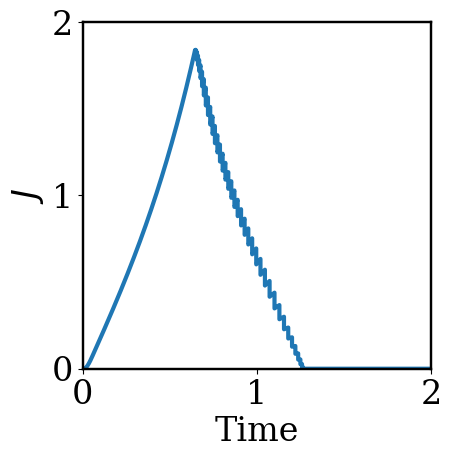

In [ ]:
J_tr = Current_density(velocity_tr,Tr_charge)
plt.plot(time,J_tr,lw=3)
plt.xlim(0,2)
plt.xlabel('Time')
plt.ylim(0,2)
plt.ylabel('$J$')

plt.locator_params(axis='y', nbins=3)

plt.savefig('Current_tr.png', bbox_inches='tight', dpi=300)
plt.show()

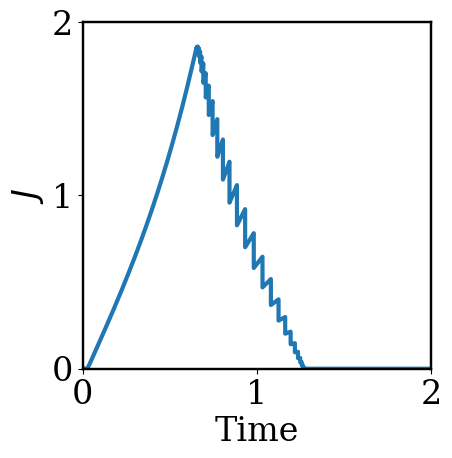

In [ ]:
J_ga = Current_density(velocity_ga,Ga_charge)
plt.plot(time,J_ga,lw=3)
plt.xlim(0,2)
plt.xlabel('Time')
plt.ylim(0,2)
plt.ylabel('$J$')

plt.locator_params(axis='y', nbins=3)
plt.savefig('Current_ga.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# plt.plot(time*1e12,-J_tr*1e-4,lw=3)
# plt.plot(time*1e12,-J_ga*1e-4,lw=3)
# plt.plot(time*1e12,-J_sq*1e-4,lw=3)

In [ ]:
ff = [.5,1,1.5]
k = 0.1

J_sq_l = []
J_ga_l = []
J_tr_l = []
for i in range(len(ff)):
  Sq_Params_sys = [k*Dt,ff[i]*Sq_mass,fp*Sq_charge,V0,d]
  Tr_Params_sys = [k*Dt,ff[i]*Tr_mass,fp*Tr_charge,V0,d]
  Ga_Params_sys = [k*Dt,ff[i]*Ga_mass,fp*Ga_charge,V0,d]

  position_sq,velocity_sq,E_field_sq = Simulation(3,Sq_Params_sys,ini_conds,iterations)
  position_tr,velocity_tr,E_field_tr = Simulation(3,Tr_Params_sys,ini_conds,iterations)
  position_ga,velocity_ga,E_field_ga = Simulation(3,Ga_Params_sys,ini_conds,iterations)

  J_sq_l.append(Current_density(velocity_sq,Sq_charge))
  J_ga_l.append(Current_density(velocity_ga,Ga_charge))
  J_tr_l.append(Current_density(velocity_tr,Tr_charge))

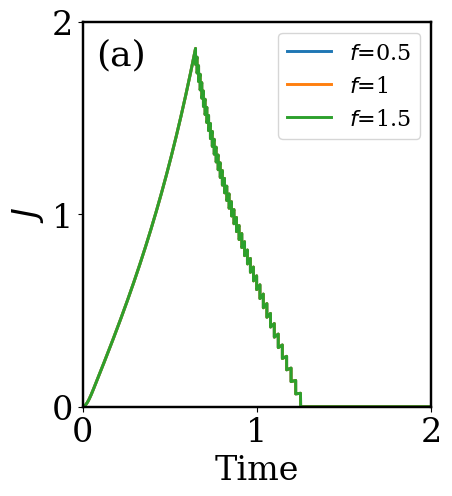

In [ ]:
plt.figure(figsize=(4.5,5))
plt.text(0.075, 1.775, '(a)', fontsize=26)
plt.locator_params(axis='y', nbins=3)
for i in range(len(ff)):

  plt.plot(time,J_sq_l[i],lw=2.1,label=f"$f$={ff[i]}")
  plt.xlim(0,2)
  plt.xlabel('Time')
  plt.ylim(0,2)
  plt.ylabel('$J$')
  plt.legend(fontsize=16.)
  plt.locator_params(axis='y', nbins=3)

plt.savefig('Current_sqm.png', bbox_inches='tight', dpi=300)

  # plt.show()


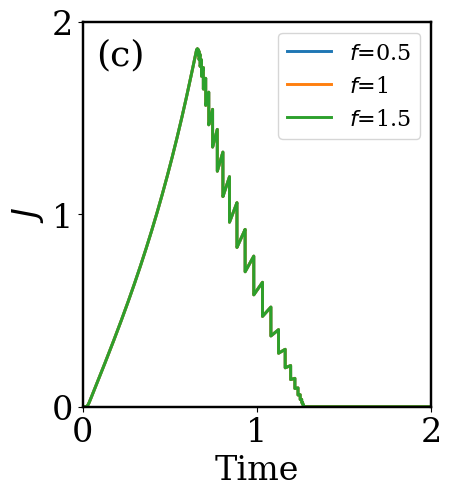

In [ ]:
plt.figure(figsize=(4.5,5))
plt.text(0.075, 1.775, '(c)', fontsize=26)
plt.locator_params(axis='y', nbins=3)
for i in range(len(ff)):
  plt.plot(time,J_ga_l[i],lw=2.1,label=f"$f$={ff[i]}")
  plt.xlim(0,2)
  plt.xlabel('Time')
  plt.ylim(0,2)
  plt.ylabel('$J$')
  plt.locator_params(axis='y', nbins=3)

  plt.legend(fontsize=16)
  # plt.text(2, 1.35, '(f)', fontsize=18)
plt.savefig('Current_gam.png', bbox_inches='tight', dpi=300)

  # plt.show()

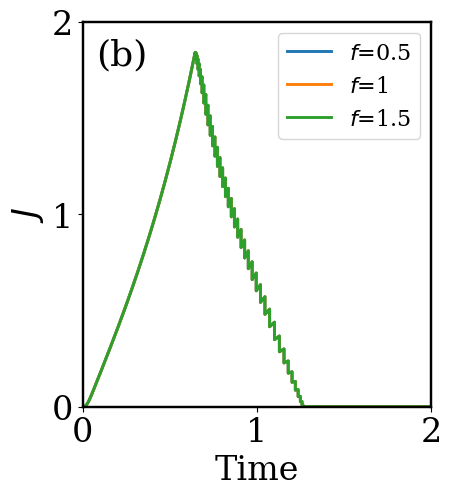

In [ ]:
plt.figure(figsize=(4.5,5))
plt.locator_params(axis='y', nbins=3)
plt.text(0.075, 1.775, '(b)', fontsize=26)

for i in range(len(ff)):
  plt.plot(time,J_tr_l[i],lw=2.1,label=f"$f$={ff[i]}")
  plt.xlim(0,2)
  plt.xlabel('Time')
  plt.ylim(0,2)
  plt.ylabel('$J$')

  plt.legend(fontsize=16)
plt.savefig('Current_trm.png', bbox_inches='tight', dpi=300)

  # plt.show()

### 1.3 Field on Cathode

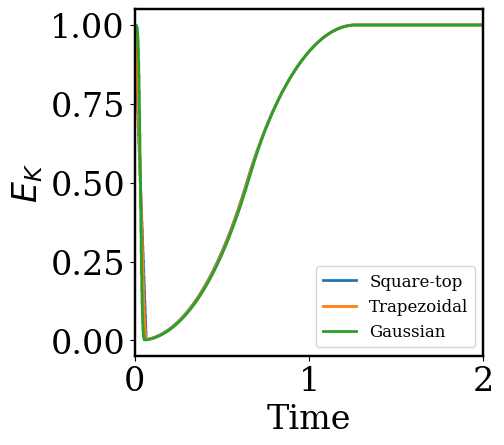

In [ ]:
E_cathode_sq = Field_cathode(position_sq,Sq_charge,V0,d)
E_cathode_tr = Field_cathode(position_tr,Tr_charge,V0,d)
E_cathode_ga = Field_cathode(position_ga,Ga_charge,V0,d)
plt.plot(time,E_cathode_sq,lw=2,label= 'Square-top')
plt.plot(time,E_cathode_tr,lw=2,label= 'Trapezoidal')
plt.plot(time,E_cathode_ga,lw=2,label= 'Gaussian')
plt.xlim(0,2)
plt.xlabel('Time')
# plt.ylim(0,1.5)
plt.ylabel('$E_K$')
# plt.xscale('log')
plt.savefig('E_cathode_sq.jpg', dpi=400)

plt.legend(fontsize=12)
plt.show()

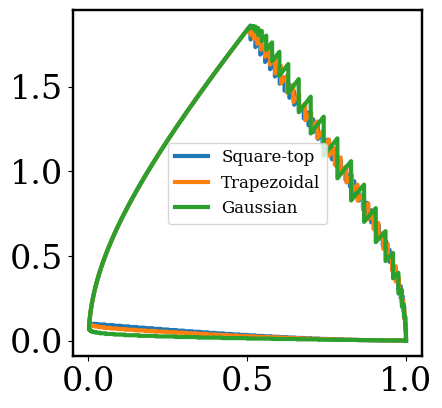

In [ ]:
plt.plot(E_cathode_sq,J_sq,lw =3,label= 'Square-top')
plt.plot(E_cathode_tr,J_tr,lw =3,label= 'Trapezoidal')
plt.plot(E_cathode_ga,J_ga,lw =3,label= 'Gaussian')
plt.legend(fontsize=12)
plt.show()

### 1.4 Potential

In [ ]:
position_sq[0,-1] - position_sq[-1,-1]

-1.0001394555070724

## 2. Evolution Snapshots

In [ ]:
size = 19
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

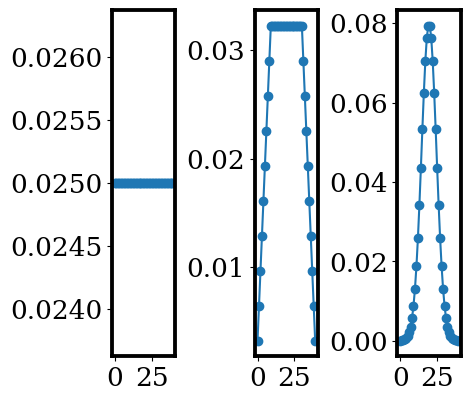

In [ ]:
# Sq_charge = pulse_profile(M,1)*charge
# Tr_charge = pulse_profile(M,1,Type = 'trapezoid')*charge*M
# Ga_charge = pulse_profile(M,1,Type = 'gauss')*charge*M

# Sq_mass = pulse_profile(M,1)*mass
# Tr_mass = pulse_profile(M,1,Type = 'trapezoid')*mass*M
# Ga_mass = pulse_profile(M,1,Type = 'gauss')*mass*M

# set the spacing between subplots
plt.subplots_adjust(wspace=1.25)

plt.subplot(131)
plt.plot(Sq_charge,'o-')

plt.subplot(132)
plt.plot(Tr_charge,'o-')

plt.subplot(133)
plt.plot(Ga_charge,'o-')
# print(Ga_charge)

Sq_Params_sys = [Dt,Sq_mass,Sq_charge,V0,d]
Tr_Params_sys = [Dt,Tr_mass,Tr_charge,V0,d]
Ga_Params_sys = [Dt,Ga_mass,Ga_charge,V0,d]

In [ ]:
charge_mult = []
mass_mult = []
for i in range(1):
    charge_mult.append(Sq_charge)
    charge_mult.append(Tr_charge)
    charge_mult.append(Ga_charge)

    mass_mult.append(Sq_mass)
    mass_mult.append(Tr_mass)
    mass_mult.append(Ga_mass)

In [ ]:
np.sum(Sq_mass)

40.0

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []

for i in range(3):

    Mass  = mass_mult[i]
    Charge = charge_mult[i]

    Params_sys = [.1*Dt,Mass,Charge,V0,d]

    res_ = Simulation(3,Params_sys,ini_conds,iterations)

    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

In [ ]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=2):
    prof = ['Square','Trapezoidal','Gaussian']
    lag = 2000

    len_rho = len(rho)

    for i in range(1,n+2):
        if i == n:
            lag = lag - 1

        plt.figure(figsize=(10,2.75))

        for j in range(len_rho):

            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.locator_params(axis='y', nbins=3)

#             plt.title("Pulse profile")
            plt.plot(shape[0],shape[1],lw=3,label=f"{prof[j]}")
#             plt.plot(shape[0],shape[1],lw=3,label=f"a = {round(1/psum[j],2)}, b= {2*((j+1)*2.5)**2}")

#             plt.xlabel("Position")
            plt.ylabel("$\\rho$")
            # if i == n+1:
            # plt.xlabel('$x$')

              # if i ==1:
            plt.legend(fontsize=14)
            plt.xlim(0,1)
            plt.ylim(0,.1)
        ######################################################

            K = np.array([0])
            A = np.array([1.5])
            E_K = np.array([field[1][-1]])
            E_A = np.array([field[1][0]])
            con1 = np.concatenate((A, field[0],K))
            con2 = np.concatenate((E_A, field[1],E_K))

            plt.subplot(1,3,2)
#             plt.title("E field")
#             plt.plot(field[0],field[1],lw=3)
            plt.plot(con1,con2,lw=3)
#             plt.xlabel("Position")
            plt.ylabel('$E$')
            # plt.yscale('log')
            plt.xlim(0,1)
            # if i == n+1:
            # plt.xlabel('$x$')

        ######################################################

            plt.subplot(1,3,3)
#             plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=3)
#             plt.xlabel("Position")
            plt.ylabel("$v$")
            plt.xlim(0,1)
            # if i == n+1:
            # plt.xlabel('$x$')

            plt.tight_layout(pad=.01)

        plt.savefig(f'snapshots_ga2{i}.png', dpi=300)
        plt.show()

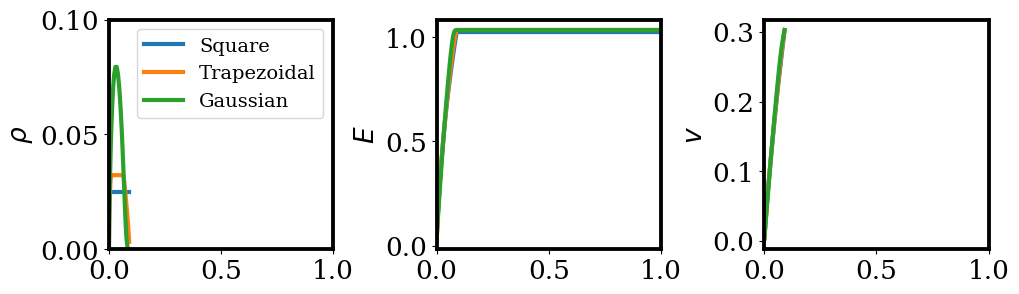

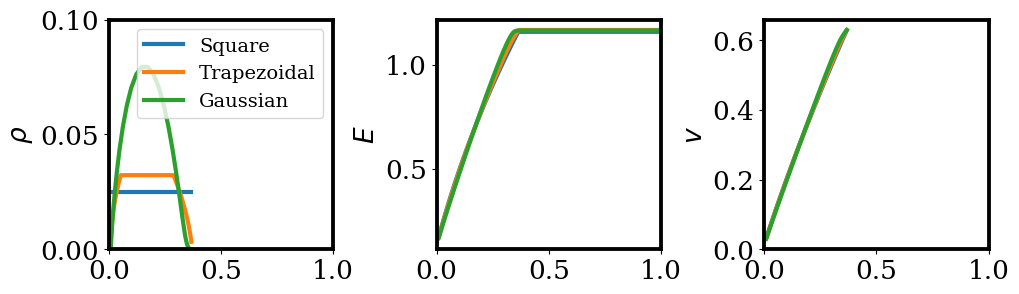

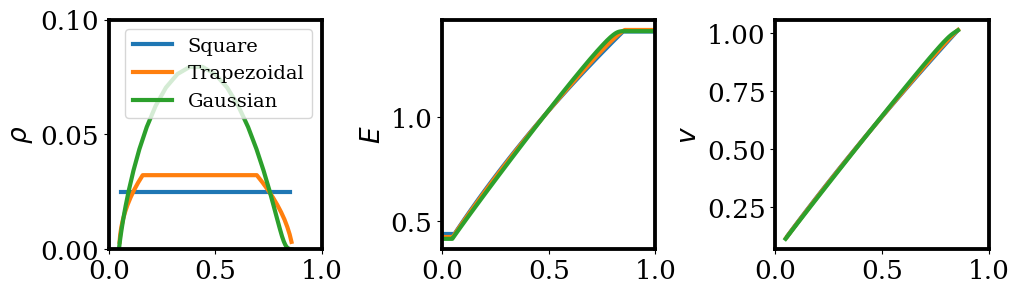

In [ ]:
plots_shape_phase_mult(position_mult,velocity_mult,E_field_mult,charge_mult)

In [ ]:
Sq_charge_mult = []
Sq_mass_mult = []
for i in range(1):
    Sq_charge_mult.append(Sq_charge)
    Sq_mass_mult.append(Sq_mass)

In [ ]:
position_sq_mult = []
velocity_sq_mult = []
E_field_sq_mult = []

k = np.array([0.1,0.25,.5,.75,1])

for i in range(1):

    Sq_Params_sys = [k[i]*Dt,Sq_mass,Sq_charge,V0,d]

    res_ = Simulation(3,Sq_Params_sys,ini_conds,iterations)

    position_sq_mult.append(res_[0])
    velocity_sq_mult.append(res_[1])
    E_field_sq_mult.append(res_[2])

In [ ]:
# position_g_mult = []
# velocity_g_mult = []
# E_field_g_mult = []

# for i in range(4):

#     Ga_charge = Ga_charge_mult[i]
#     Ga_mass = Ga_mass_mult[i]

#     Ga_Params_sys = [.1*Dt,Ga_mass,Ga_charge,V0,d]

#     res_ = Simulation(3,Ga_Params_sys,ini_conds,iterations)

#     position_g_mult.append(res_[0])
#     velocity_g_mult.append(res_[1])
#     E_field_g_mult.append(res_[2])

In [ ]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=2):

#     lag = int(len(position[0])/n)

    lag = 2000

    len_rho = len(rho)

    psum = [6.2665706768411304,12.499856013286099,17.94732608456735,21.721125396120463]

    for i in range(1,n+2):
        if i == n:
            lag = lag - 1

        plt.figure(figsize=(10,2.75))

#         print(i*lag*Dt_b*Tcl/T0)


        for j in range(len_rho):

            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.locator_params(axis='y', nbins=3)
#             plt.title("Pulse profile")

            f = [0.1,0.25,.5,.75,1]

            plt.plot(shape[0],shape[1],lw=3,label=f"$f$ = {f[j]}")
#             plt.plot(shape[0],shape[1],lw=3,label=f"a = {round(1/psum[j],2)}, b= {2*((j+1)*2.5)**2}")

#             plt.xlabel("Position")
            plt.ylabel("$\\rho$")
          # if i == n+1:
            plt.xlabel('$x$')

            # if i ==1:
            # plt.legend(fontsize=14)
            plt.xlim(0,1)
            plt.ylim(0,.1)
        ######################################################


            K = np.array([0])
            A = np.array([1.5])
            E_K = np.array([field[1][-1]])
            E_A = np.array([field[1][0]])
            con1 = np.concatenate((A, field[0],K))
            con2 = np.concatenate((E_A, field[1],E_K))

            plt.subplot(1,3,2)
#             plt.title("E field")
#             plt.plot(field[0],field[1],lw=3)
            plt.plot(con1,con2,lw=3)
#             plt.xlabel("Position")
            plt.ylabel('$E$')
            plt.xlim(0,1)

            plt.xlabel('$x$')

        ######################################################

            plt.subplot(1,3,3)
#             plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=3)
#             plt.xlabel("Position")
            plt.ylabel("$v$")
            plt.xlim(0,1)
        # if i == n+1:
            plt.xlabel('$x$')

            plt.tight_layout(pad=.25)

        plt.savefig(f'snapshots_ga2{i}.png', dpi=300)
        plt.show()

12.532369520882824
12.532369520882824
12.532369520882824
12.532369520882824
12.532369520882824
12.532369520882824
12.532369520882824
12.532369520882824
12.532369520882824
12.532369520882824


Text(0, 0.5, '$\\rho$')

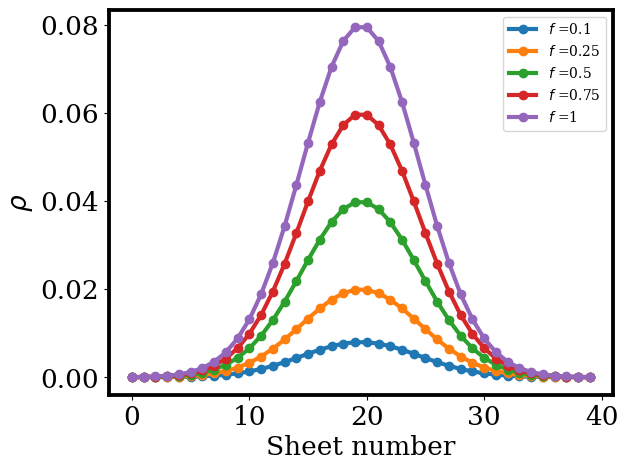

In [ ]:
Ga_charge_mult2 = []
Ga_mass_mult2 = []
f = [0.1,0.25,.5,.75,1]

for i in range(5):
    Ga_charge_mult2.append(f[i]*pulse_profile(M,1,'gauss'))
    Ga_mass_mult2.append(pulse_profile(M,1,'gauss'))

Ga_mass_mult2 = np.array(Ga_mass_mult2)
Ga_charge_mult2 = np.array(Ga_charge_mult2)

plt.figure(figsize=(6.5, 5))
for i in range(5):
    plt.plot(Ga_charge_mult2[i],'o-',lw=3,label=f"$f$ ={f[i]}")
    plt.legend(fontsize="10")

plt.xlabel('Sheet number')
plt.ylabel('$\\rho$')

In [ ]:
np.sum(Ga_charge_mult2[3])

0.7500000000000002

In [ ]:
position_g_mult2 = []
velocity_g_mult2 = []
E_field_g_mult2 = []

for i in range(5):

    Ga_charge2 = Ga_charge_mult2[i]
    Ga_mass2 = Ga_mass_mult2[i]

    Ga_Params_sys2 = [.1*Dt,Ga_mass2,Ga_charge2,V0,d]

    res_2 = Simulation(3,Ga_Params_sys2,ini_conds,iterations)

    position_g_mult2.append(res_2[0])
    velocity_g_mult2.append(res_2[1])
    E_field_g_mult2.append(res_2[2])

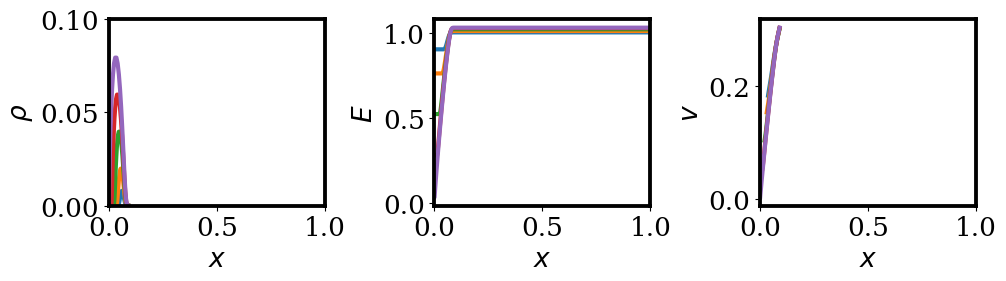

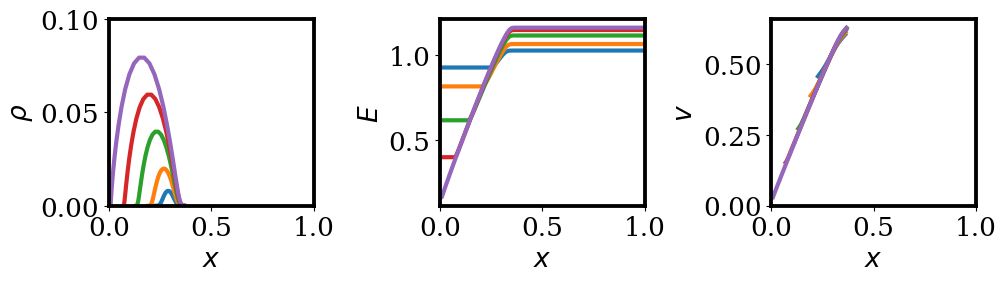

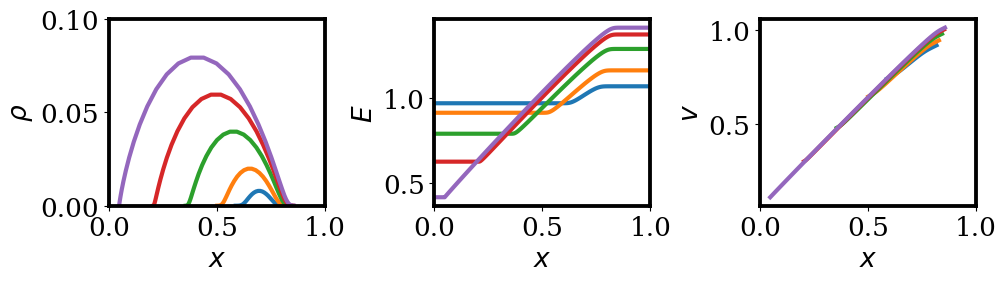

In [ ]:
plots_shape_phase_mult(position_g_mult2,velocity_g_mult2,E_field_g_mult2,Ga_charge_mult2)

### 1.5 Distorsion of the pulse

In [ ]:
def th_distor(f,k):
  dist = (f**1)/k
  return dist

## 1.7 Current limits

In [ ]:
Sq_charge = pulse_profile(M,1)*charge
Tr_charge = pulse_profile(M,1,Type = 'trapezoid')
Ga_charge = pulse_profile(M,1,Type = 'gauss')

Sq_mass = pulse_profile(M,1)
Tr_mass = pulse_profile(M,1,Type = 'trapezoid')
Ga_mass = pulse_profile(M,1,Type = 'gauss')

12.532369520882824
12.532369520882824


In [ ]:
Tau_val = np.linspace(0.1,1)
Jcrit_s = Norm_J_crit_s(Tau_val)
Jcrit_e = Norm_J_crit_e(Tau_val)

### Square-top

In [ ]:
Voltage = [V0]
distance = [d]

k_range = [0.1,0.25,0.5,0.75,1]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_sq = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=1
        Params_sys = [k*Dt,Sq_mass*f,Sq_charge*f,Vg,dist]
        while not limit_charge(3,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,Sq_mass*f,Sq_charge*f,Vg,dist]
            f +=0.005
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_sq.append(f)
    f_limit_sq =np.array(f_limit_sq)

    print(" ")

    Jc_sq = (3/4)*f_limit_sq/k_range

Simulation 1/1
 
1.0249999999999995
*** 20.0 % ***
1.0349999999999993
*** 40.0 % ***
1.0849999999999982
*** 60.0 % ***
1.1799999999999962
*** 80.0 % ***
1.3399999999999928
*** 100.0 % ***
 


In [ ]:
f

1.3399999999999928

### Trapezoid

In [ ]:
Voltage = [V0]
distance = [d]

k_range = [0.1,0.25,0.5,0.75,1]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_tr = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=1
        Params_sys = [k*Dt,Tr_mass*f,Tr_charge*f,Vg,dist]
        while not limit_charge(3,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,Tr_mass*f,Tr_charge*f,Vg,dist]
            f +=0.005
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_tr.append(f)
    f_limit_tr =np.array(f_limit_tr)

    print(" ")

    Jc_tr = (3/4)*f_limit_tr/k_range

Simulation 1/1
 
1.0099999999999998
*** 20.0 % ***
1.0249999999999995
*** 40.0 % ***
1.0649999999999986
*** 60.0 % ***
1.139999999999997
*** 80.0 % ***
1.2449999999999948
*** 100.0 % ***
 


### Gaussian

In [ ]:
Voltage = [V0]
distance = [d]

k_range = [0.1,0.25,0.5,0.75,1]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_ga = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=1
        Params_sys = [k*Dt,Ga_mass*f,Ga_charge*f,Vg,dist]
        while not limit_charge(3,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,Ga_mass*f,Ga_charge*f,Vg,dist]
            f +=0.005
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_ga.append(f)
    f_limit_ga =np.array(f_limit_ga)

    print(" ")

    Jc_ga = (3/4)*f_limit_ga/k_range

Simulation 1/1
 
1.0099999999999998
*** 20.0 % ***
1.0149999999999997
*** 40.0 % ***
1.0349999999999993
*** 60.0 % ***
1.0599999999999987
*** 80.0 % ***
1.089999999999998
*** 100.0 % ***
 


In [ ]:
f

1.089999999999998

In [ ]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator

size = 20
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':1.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

<ipython-input-113-6d02611d976f>:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10)


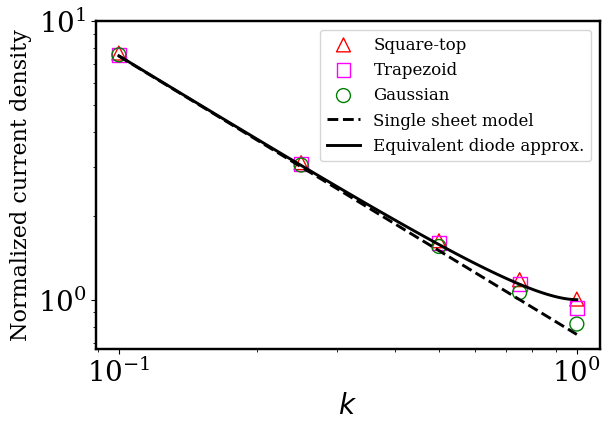

In [ ]:
plt.figure(figsize=(6.5,4.25))
plt.scatter(k_range,Jc_sq,marker='^',s=100,edgecolors='r',facecolors='none',label='Square-top')
plt.scatter(k_range,Jc_tr,marker='s',s=100,edgecolors='magenta',facecolors='none',label='Trapezoid')
plt.scatter(k_range,Jc_ga,marker='o',s=100,edgecolors='g',facecolors='none',label='Gaussian')
plt.plot(Tau_val,Jcrit_s,'--',color='black',lw=2.1,label='Single sheet model')
plt.plot(Tau_val,Jcrit_e,'black',lw=2.1,label='Equivalent diode approx.')

plt.ylabel('Normalized current density',fontsize=16)
plt.xlabel('$k$')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12)

plt.ylim(0,10)

plt.show()

In [ ]:
Tau_val

array([0.1       , 0.11836735, 0.13673469, 0.15510204, 0.17346939,
       0.19183673, 0.21020408, 0.22857143, 0.24693878, 0.26530612,
       0.28367347, 0.30204082, 0.32040816, 0.33877551, 0.35714286,
       0.3755102 , 0.39387755, 0.4122449 , 0.43061224, 0.44897959,
       0.46734694, 0.48571429, 0.50408163, 0.52244898, 0.54081633,
       0.55918367, 0.57755102, 0.59591837, 0.61428571, 0.63265306,
       0.65102041, 0.66938776, 0.6877551 , 0.70612245, 0.7244898 ,
       0.74285714, 0.76122449, 0.77959184, 0.79795918, 0.81632653,
       0.83469388, 0.85306122, 0.87142857, 0.88979592, 0.90816327,
       0.92653061, 0.94489796, 0.96326531, 0.98163265, 1.        ])

In [ ]:
cst.e

1.602176634e-19

In [ ]:
cst.epsilon_0

8.8541878128e-12

In [ ]:
cst.m_e

9.1093837015e-31

In [ ]:
def th_distorsion(tp):
  dist = 0.5/tp
  return

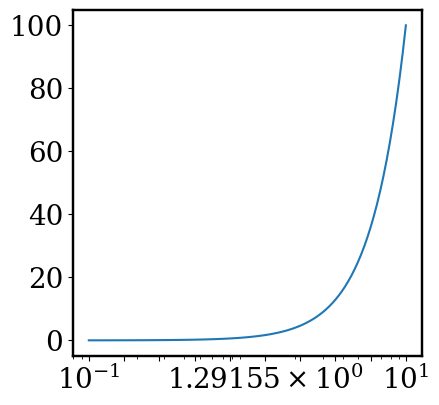

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
x = np.logspace(-1, 1, 100)
y = x**2  # Replace this with your actual data

# Create the plot
plt.plot(x, y)
plt.xscale('log')

# Specify the locations where you want tick marks
# Adjust the values in the np.logspace() call to suit your needs
custom_ticks = np.logspace(-1, 1, 10)

# Set the x-axis ticks at the specified locations
plt.xticks(custom_ticks)

# Show the plot
plt.show()
